# Data Denizens Progress Report
By: Chi Hieu Nguyen, Jesus Rojas, Daniel Rodriguez, Dinh Dang Khoa Tran, Duc Tam Nguyen

### Project Introduction
Our data science project seeks to analyze and predict the playoff performance of NBA teams and individual players using a combination of regular season statistics and performance against playoff-caliber opponents. The goal is to determine whether we can accurately forecast postseason outcomes, such as a team’s playoff success or a player's postseason statline, based on regular season trends and contextualized performance data.
One of the core issues with evaluating NBA performance is the distinct contrast between the regular season and the playoffs. Playoff games feature slower pace, increased defensive intensity, tighter rotations, and more targeted game planning. As a result, regular season metrics do not always carry over and some teams and players excel when the stakes are lower, while others elevate their game under pressure. This is an important issue for our stakeholders (NBA coaches, teams, analysts, and fans) because we seek to provide meaningful insight to the most important stretch of games in the NBA. This insight will be greatly important for understanding which players to give more minutes to in the playoffs, as giving the wrong players minutes can lead to a teams short exit in the postseason.
To address this, we’re going beyond just overall regular season stats and win percentage. A key feature of our approach is to isolate regular season performance against other playoff-bound teams, under the assumption that these matchups more closely reflect the intensity and structure of playoff basketball. By focusing on how teams fare against high-level competition, we hope to identify patterns that traditional season-long averages might hide. Our interest in this topic stems from both a passion for basketball and the analytical challenges the NBA presents. With its rich dataset and clear regular season vs. postseason split, the NBA offers an ideal setting to explore how performance under pressure can be modeled and understood.

### Changes from Original Proposal
One change that was made from the original proposal is to include more data from different years. Previously, we planned on using only the regular season for 2024-2025, but we quickly realized that we need to provide other years for our model to train on so it can accurately predict playoff outcomes. That is why we dedcided on using the previous three years of regular season and playoff data in our approach.

### Data cleaning
Data cleaning is done in the team_individual_stat file. The following steps were performed to clean the dataset.
 Step 1:
All column names are converted to uppercase (and extra whitespace is removed) to ensure consistency in later steps.

Steps 2 & 3:
Duplicate rows are removed, and columns that are not relevant (any column with "RANK" in its name plus extra identifier columns like NICKNAME, W, L, and W_PCT) are dropped.

Step 4:
Rows with any missing values are dropped to ensure data integrity.

Step 5:
The function attempts to convert columns (except for key non-numeric ones like PLAYER_NAME, TEAM_ABBREVIATION, and SEASON) to numeric types, which facilitates any numerical analysis.

Step 6:
Column names are ensured to remain uppercase and stripped of whitespace.


In [11]:
import pandas as pd
import team_individual_stat

# Now you can use the function in your notebook:
df = pd.read_csv('player_per_game_stats_regular_2425.xls')
df = team_individual_stat.wrangle_player_performance(df)
df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,MIN,FGM,FGA,FG_PCT,...,TOV,STL,BLK,PF,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,SEASON
0,1630639,A.J. Lawson,1610612761,TOR,24.0,20,17.1,2.8,7.0,0.400,...,0.4,0.3,0.2,1.6,8.1,-0.9,14.2,1,0,2024-25
1,1631260,AJ Green,1610612749,MIL,25.0,66,22.6,2.5,5.9,0.423,...,0.6,0.5,0.1,2.2,7.4,1.7,13.6,0,0,2024-25
2,1642358,AJ Johnson,1610612764,WAS,20.0,23,18.8,2.6,6.2,0.415,...,1.1,0.4,0.1,1.1,7.0,-2.3,13.6,0,0,2024-25
3,203932,Aaron Gordon,1610612743,DEN,29.0,46,27.8,5.0,9.4,0.530,...,1.4,0.4,0.2,1.6,14.3,5.7,25.5,3,0,2024-25
4,1628988,Aaron Holiday,1610612745,HOU,28.0,57,12.8,1.8,4.2,0.430,...,0.6,0.3,0.2,1.0,5.3,1.6,9.7,0,0,2024-25


In [12]:
#code to show some of the datas values. show column names

## EDA & Visualization

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from analyze_win_percentages import analyze_win_percentages
import get_data
from get_data import fetch_bbr_player_avg_stats, fetch_bbr_playoffs_stats

### Data Preparation

First, we need to fetch and preprocess our data using out data cleaner.

In [28]:
def custom_preprocess(df):
    """Custom preprocessing function that safely handles numeric conversions"""
    df = df.copy()
    
    if "Awards" in df.columns:
        df = df.drop(columns=["Awards"])
    
    if "Rk" in df.columns:
        df = df.drop(columns=["Rk"])
    
    df.columns = [
        col.strip().lower().replace(" ", "_").replace("%", "pct") for col in df.columns
    ]
    
    pct_cols = ["fgpct", "3pct", "2pct", "efgpct", "ftpct"]
    for col in pct_cols:
        if col in df.columns:
            if df[col].dtype == "object":
                df[col] = df[col].str.strip("%")
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
                
    for col in df.columns:
        if col not in pct_cols and col not in ["player", "tm", "pos"]:
            if df[col].dtype == "object":
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
    
    return df

In [29]:
# Fetch data for last 3 seasons
seasons = ["2021-22", "2022-23", "2023-24"]
all_regular_data = []
all_playoff_data = []

print("Fetching data for multiple seasons...")
for season in seasons:
    print(f"Fetching {season} regular season data...")
    regular_season = fetch_bbr_player_avg_stats(season)
    regular_season['season'] = season
    all_regular_data.append(custom_preprocess(regular_season))
    
    print(f"Fetching {season} playoff data...")
    playoffs = fetch_bbr_playoffs_stats(season)
    playoffs['season'] = season
    all_playoff_data.append(custom_preprocess(playoffs))

# Combine all seasons
regular_stats = pd.concat(all_regular_data)
playoff_stats = pd.concat(all_playoff_data)

print(f"Combined regular season data shape: {regular_stats.shape}")
print(f"Combined playoff data shape: {playoff_stats.shape}")

Fetching data for multiple seasons...
Fetching 2021-22 regular season data...
Fetching 2021-22 playoff data...
Fetching 2022-23 regular season data...
Fetching 2022-23 playoff data...
Fetching 2023-24 regular season data...
Fetching 2023-24 playoff data...
Combined regular season data shape: (2229, 30)
Combined playoff data shape: (648, 30)


### Dataset Overview

1. Sample Size: Contains data for 735-736 players
2. Age Range: Players range from 19 to 39 years old (mean: 26.16 years)
3. Playing Time: Highly variable with players averaging between 0.5 to 37.8 minutes per game

**Playing Time Distribution**
1. Wide spread in games played (1-84 games)
2. Only about half of players start regularly (median games started: 5)
3. Significant minutes difference (standard deviation: 9.74 minutes)

**Scoring Patterns**
1. Average scoring: 8.02 points per game
2. High variance in scoring (SD: 6.48 points)
3. Top scorers reaching 34.7 points per game
4. 75% of players score below 11.05 points per game

**Shooting Efficiency**
1. Average FG%: 45% (fairly consistent with SD of 11%)
2 . Free throw shooting averages 75%
3. Three-point attempts (2.58 average) about 40% of total field goal attempts
   
**Potential Data Issues**
1. Problem in the "team" column (all values are 0)

In [30]:
regular_stats.describe().round(2)

,age,team,g,gs,mp,fg,fga,fgpct,3p,3pa,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
count,2226.00,2229.0,2226.00,2226.00,2226.00,2226.00,2226.00,2203.00,2226.00,2226.00,...,2226.00,2226.00,2226.00,2226.00,2226.00,2226.00,2226.00,2226.00,2226.00,2229.0
mean,26.08,0.0,40.11,18.29,18.63,3.02,6.56,0.45,0.92,2.64,...,0.82,2.52,3.34,1.91,0.59,0.37,0.99,1.56,8.20,0.0
std,4.24,0.0,25.58,24.85,9.62,2.32,4.74,0.12,0.85,2.20,...,0.74,1.75,2.32,1.84,0.41,0.38,0.79,0.80,6.42,0.0
min,19.00,0.0,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,23.00,0.0,16.00,0.00,11.10,1.30,3.10,0.40,0.20,0.90,...,0.30,1.30,1.70,0.70,0.30,0.10,0.43,1.00,3.50,0.0
50%,25.00,0.0,41.00,5.00,17.70,2.40,5.20,0.45,0.70,2.20,...,0.60,2.20,2.90,1.30,0.50,0.30,0.80,1.60,6.50,0.0
75%,29.00,0.0,64.00,29.00,26.58,4.10,8.80,0.50,1.40,3.90,...,1.10,3.40,4.40,2.50,0.80,0.50,1.30,2.10,11.00,0.0
max,42.00,0.0,84.00,83.00,43.50,11.50,23.60,1.00,4.90,11.80,...,5.10,11.00,14.70,10.90,3.00,3.60,4.80,5.00,34.70,0.0


## Regular Season vs. Playoff Performance

### Hypothesis: Players shoot differently in playoffs compared to regular season

It's crucial to know which players maintain or do better in high pressure playoff situations. We can compare field goal percentages between regular season and playoffs to find any patterns.

In [31]:
if "player" in regular_stats.columns and "player" in playoff_stats.columns:
    merged_data = pd.merge(
        regular_stats, playoff_stats, on=["player", "season"], suffixes=("_regular", "_playoff")
    )
    
    print(f"Number of player-seasons in both regular season and playoffs: {len(merged_data)}")
    
    min_mp = 15  # Minimum minutes per game
    filtered_data = merged_data[
        (merged_data["mp_regular"] >= min_mp) & (merged_data["mp_playoff"] >= min_mp)
    ]
    
    fg_diff = filtered_data["fgpct_playoff"] - filtered_data["fgpct_regular"]
    avg_diff = fg_diff.mean()
    print(f"Average difference in FG% (Playoff - Regular): {avg_diff:.4f}")
    
    # Count how many players improved
    improved = (fg_diff > 0).sum()
    declined = (fg_diff < 0).sum()
    same = (fg_diff == 0).sum()
    print(f"Players with improved FG% in playoffs: {improved} ({improved/len(fg_diff):.1%})")
    print(f"Players with declined FG% in playoffs: {declined} ({declined/len(fg_diff):.1%})")
    print(f"Players with unchanged FG% in playoffs: {same} ({same/len(fg_diff):.1%})")

Number of player-seasons in both regular season and playoffs: 2304
Average difference in FG% (Playoff - Regular): -0.0180
Players with improved FG% in playoffs: 457 (35.7%)
Players with declined FG% in playoffs: 815 (63.6%)
Players with unchanged FG% in playoffs: 9 (0.7%)


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=filtered_data["fgpct_regular"],
    y=filtered_data["fgpct_playoff"],
    mode='markers',
    hovertemplate="<b>Player:</b> %{text}<br>" +
                  "Mins Played: %{customdata[0]}<br>" +
                  "Mins Played Playoffs: %{customdata[1]}<br>" +
                  "Regular Season FG%: %{x:.3f}<br>" +
                  "Playoff FG%: %{y:.3f}<br>" +
                  "<extra></extra>",
    text=filtered_data["player"],
    customdata=np.column_stack((filtered_data["mp_regular"], filtered_data["mp_playoff"])),
    name='Players'
))
#print(filtered_data.columns)

# Define min and max values for the diagonal line
min_val = min(filtered_data["fgpct_regular"].min(), filtered_data["fgpct_playoff"].min())
max_val = max(filtered_data["fgpct_regular"].max(), filtered_data["fgpct_playoff"].max())

fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    name='Equal Performance',
    line=dict(
        dash='dash',
        color='red'
    )
))

fig.update_layout(
    title="Regular Season vs Playoff Field Goal Percentage (2021-24 Seasons)",
    xaxis_title="Regular Season FG%",
    yaxis_title="Playoff FG%",
    width=1000,
    height=800,
    showlegend=True,
    template='plotly_white',
    hovermode='closest',
    autosize=True
)


fig.show()

### Visualization

In [33]:
df_schedule = get_data.fetch_regular_season_schedule(season='2024-25')


In [34]:
team_abbreviation_map = {
    # Western Conference Teams
    'OKC': 'Oklahoma City Thunder',
    'HOU': 'Houston Rockets',
    'DEN': 'Denver Nuggets',
    'LAL': 'Los Angeles Lakers',
    'GSW': 'Golden State Warriors',
    'MEM': 'Memphis Grizzlies',
    'DAL': 'Dallas Mavericks',
    'SAC': 'Sacramento Kings',
    'MIN': 'Minnesota Timberwolves',
    'LAC': 'Los Angeles Clippers',

    # Eastern Conference Teams
    'CLE': 'Cleveland Cavaliers',
    'BOS': 'Boston Celtics',
    'NYK': 'New York Knicks',
    'IND': 'Indiana Pacers',
    'DET': 'Detroit Pistons',
    'MIL': 'Milwaukee Bucks',
    'MIA': 'Miami Heat',
    'CHI': 'Chicago Bulls',
    'ORL': 'Orlando Magic',
    'ATL': 'Atlanta Hawks'
}

# Full list of playoff teams (used for filtering opponents)
playoff_teams = list(team_abbreviation_map.values())

# Conference team lists
western_teams = [
    'Oklahoma City Thunder', 'Houston Rockets', 'Denver Nuggets', 'Los Angeles Lakers',
    'Golden State Warriors', 'Memphis Grizzlies', 'Dallas Mavericks', 'Sacramento Kings',
    'Minnesota Timberwolves', 'Los Angeles Clippers'
]

eastern_teams = [
    'Cleveland Cavaliers', 'Boston Celtics', 'New York Knicks', 'Indiana Pacers',
    'Detroit Pistons', 'Milwaukee Bucks', 'Miami Heat', 'Chicago Bulls',
    'Orlando Magic', 'Atlanta Hawks'
]

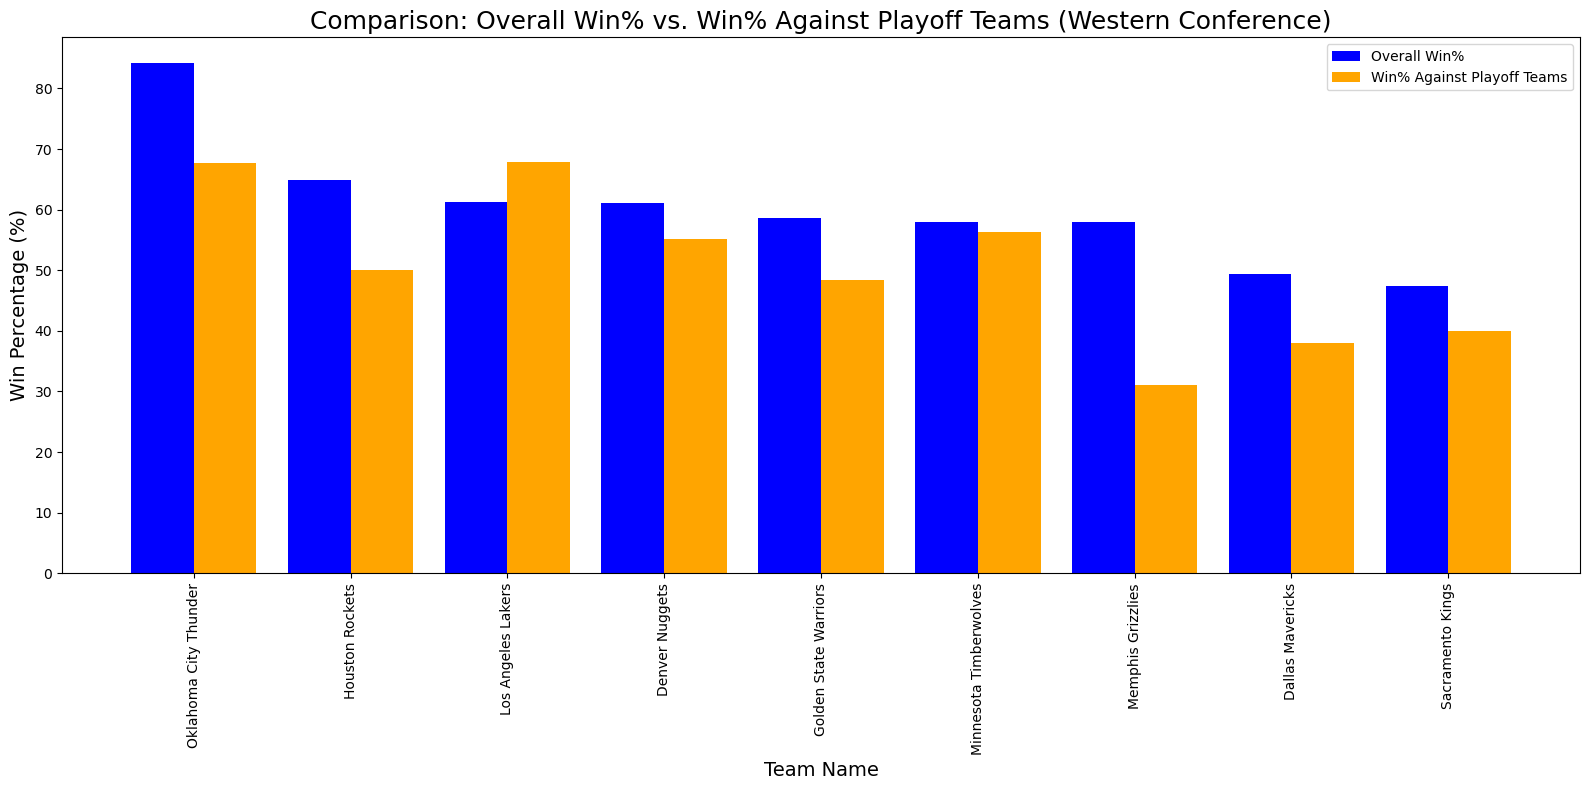

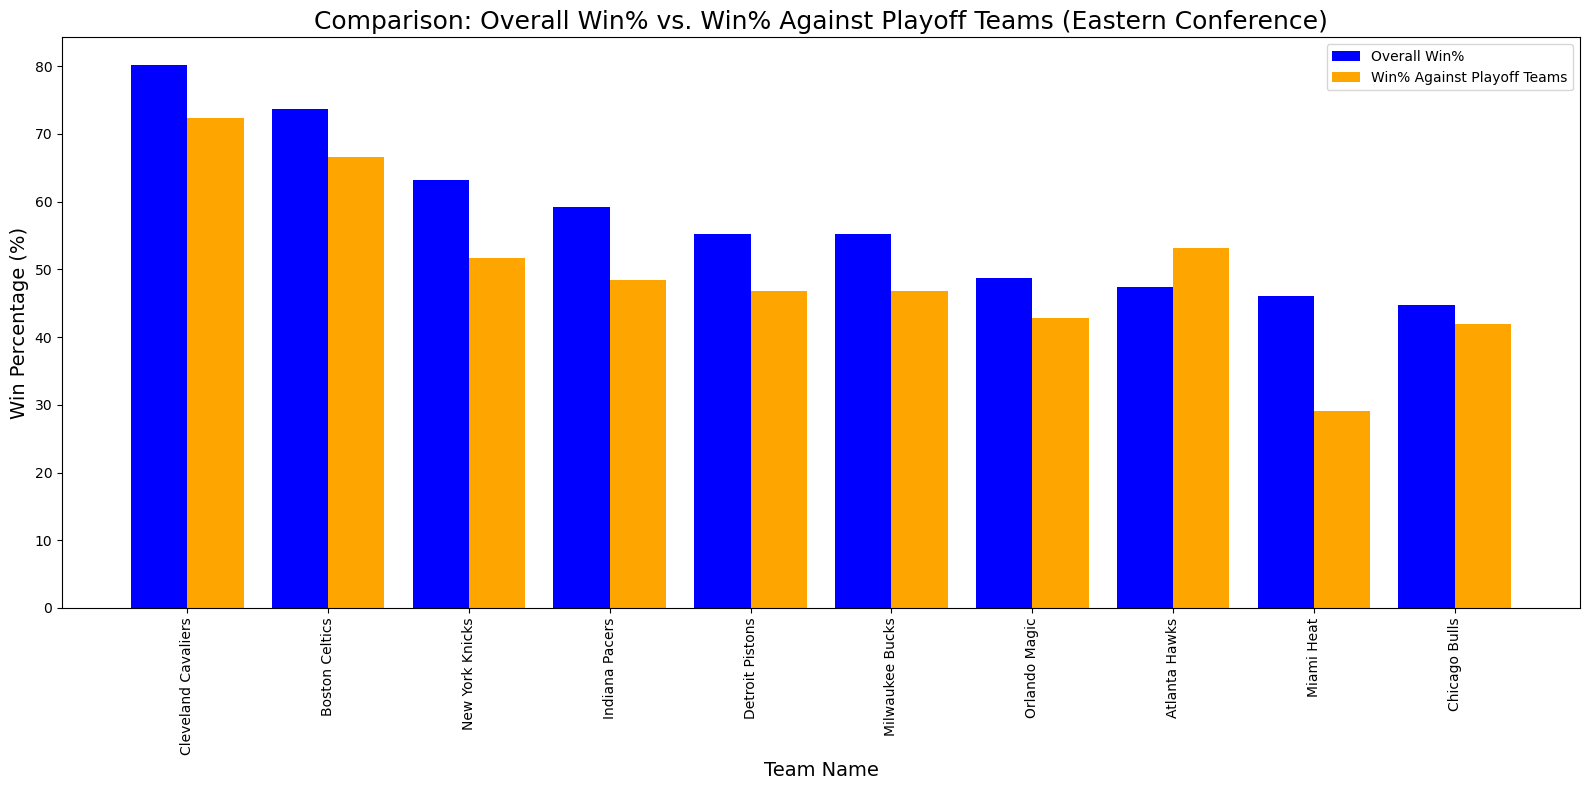

In [37]:
western_df = analyze_win_percentages(df_schedule, team_abbreviation_map, playoff_teams, western_teams, 'Western')
eastern_df = analyze_win_percentages(df_schedule, team_abbreviation_map, playoff_teams, eastern_teams, 'Eastern')

##### Column names in the cleaned dataset

In [19]:
#dataset.columns

### ML analysis


**Model**

explain how we picked and used our model, 

### Reflection: 
The hardest part that we have encountered was the exploration process of finding the right relationships between statistics that legitimately impacted playoff outcomes. Our whole group engaged in EDA's with the data and we were only able to find a handful of insightful relationships. However, now that we have found these relationships, we can build off of them and continue to delve deeper into exploring them.

We have confirmed the negative relationship that most players have with playoff performance vs. regular season performance, as most players tend to see a downtick in their field goal percentage in the playoffs.

The current biggest problem that we are facing is that... (To be determined)

The results that we have gotten indicate that we are on the right track and also prove our initial hypotheses. The relationship between field goal percentage in the playoffs vs. regular season is that in the playoffs players typically shoot lower than their average for the regular season. Additionally, teams that have a lower win percentage against playoff caliber teams typically do not have great success in the playoffs. Given these findings, we believe that it is worth proceeding with the project as we can continue to find more metrics that determine playoff success for struggling teams and we can also find players that should be played more given other metrics (assists, rebounds, steals, etc).

### Next steps: 
We plan to expand our dataset by getting the previous three years of regular season and playoff statistics. Additionally, we will continue to work on our Models to find the best Model for predicting certain outcomes.